In [137]:
import math
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [63]:
Vertex = str
Cost = float
Edge = Tuple[Vertex, Vertex, Cost]
Graph = Tuple[List[Vertex], List[Edge]]

π = math.pi

In [32]:
# Using breadth-first search
def is_strongly_connected(graph: Graph) -> bool:
  vertices, edges = graph
  visited: Dict[Vertex, bool] = {}
  for v in vertices:
    visited[v] = False
  
  queue: List[Vertex] = [vertices[0]]

  while len(queue) > 0:
    current = queue[0]
    queue = queue[1:]

    visited[current] = True
    for edge in edges:
      if edge[0] == current and not visited[edge[1]]:
        queue.append(edge[1])
      elif edge[1] == current and not visited[edge[0]]:
        queue.append(edge[0])
  
  for was_visited in visited.values():
    if not was_visited:
      return False

  return True

In [134]:
def generate_random_graph(
  min_num_vertices: int = 3,
  max_num_vertices: int = 20,
  min_edge_cost: float = 0,
  max_edge_cost: float = 1,
  min_target_connectedness: float = 0,
  max_target_connectedness: float = 1,
) -> Graph:

  num_vertices = np.random.randint(min_num_vertices, max_num_vertices+1)
  
  # Generate random distance matrix
  # NOTE: we'll only be using the values to the right of the diagonal
  distance_matrix = np.random.uniform(min_edge_cost, max_edge_cost, size=(num_vertices, num_vertices))

  # Create a fully connected graph from the distance matrix
  vertices: List[Vertex] = list(f"V{i}" for i in range(num_vertices))
  edges: List[Edge] = []
  for i, v in enumerate(vertices[:-1]):
    for j, w in enumerate(vertices[i+1:]):
      edges.append((v, w, distance_matrix[i, j]))
  
  # Randomly remove edges, making sure the graph stays strongly connected
  target_connectedness = np.random.uniform(min_target_connectedness, max_target_connectedness)
  target_num_edges_to_delete = int((1-target_connectedness) * len(edges))
  for _ in range(target_num_edges_to_delete):
    deletable_edge_indices = list(i for i, edge in enumerate(edges) if is_strongly_connected((vertices, edges[:i]+edges[i+1:])))
    if len(deletable_edge_indices) == 0:
      break
    del edges[deletable_edge_indices[np.random.randint(0, len(deletable_edge_indices))]]

  return (vertices, edges)

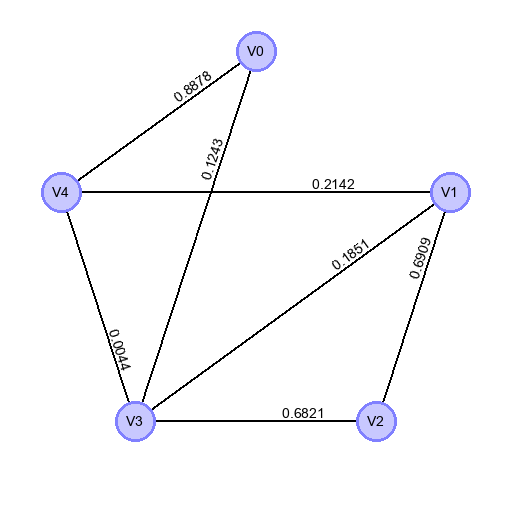

In [142]:
def draw_graph(graph: Graph) -> Image.Image:
  vertices, edges = graph
  size = 512
  im = Image.new("RGB", (size, size), (255, 255, 255))
  draw = ImageDraw.Draw(im)

  radius = size * 0.8 * 0.5
  node_size = 40
  with open("arial.ttf", "rb") as fp:
    label_font = ImageFont.truetype(fp, size=14)

  positions: Dict[Vertex, Tuple[float, float]] = {}
  
  for i, vertex in enumerate(vertices):
    θ = (i / (len(vertices)) - 0.25) * 2 * π
    x = radius * math.cos(θ) + size/2
    y = radius * math.sin(θ) + size/2
    positions[vertex] = (x, y)
  
  for (v, w, cost) in edges:
    vx, vy = positions[v]
    wx, wy = positions[w]
    color = (0, 0, 0)
    draw.line(
      (
        int(vx),
        int(vy),
        int(wx),
        int(wy)
      ),
      fill=color,
      width=2,
    )
    label_text = str(round(cost, 4))
    label_width, label_height = draw.textbbox((0, 0), label_text, font=label_font)[2:]
    label_img = Image.new("RGBA", (label_width, label_height), color=(255, 255, 255, 0))
    label_draw = ImageDraw.Draw(label_img)
    label_draw.text((0, 0), label_text, fill=color, font=label_font, anchor="lt")
    edge_angle = math.atan((wy-vy)/(wx-vx)) if wx-vx != 0 else (π/2 if wy-vy > 0 else -π/2)
    label_rotated = label_img.rotate(-math.degrees(edge_angle), resample=Image.BICUBIC, expand=True, fillcolor=(255, 255, 255, 0))
    t = 0.3
    cx = vx + t * (wx - vx)
    cy = vy + t * (wy - vy)
    cx += math.sin(edge_angle) * label_height/2
    cy -= math.cos(edge_angle) * label_height/2
    x = int(cx - label_rotated.width/2)
    y = int(cy - label_rotated.height/2)
    im.paste(label_rotated, (x, y), mask=label_rotated)

  
  for vertex in vertices:
    x, y = positions[vertex]
    draw.ellipse(
      (
        int(x - node_size/2),
        int(y - node_size/2),
        int(x + node_size/2),
        int(y + node_size/2)
      ),
      fill=(200, 200, 255),
      outline=(128, 128, 255),
      width=3
    )
    draw.text((x, y), vertex, fill="black", font=label_font, anchor="mm")

  return im

if __name__ == "__main__":
  graph = generate_random_graph(min_num_vertices=5, max_num_vertices=5)
  display.display(draw_graph(graph))